## Demo： Bayesian neural network via MCMC inference

In [13]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# local imports
from mfbml.problems import  mf_Forrester_torch
from mfbml.methods.bayes_neural_nets import BNNWrapper


# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

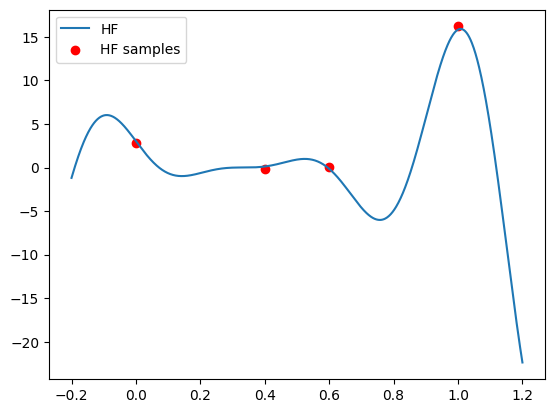

In [14]:
func = mf_Forrester_torch(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
hf_samples = torch.Tensor([0.0, 0.4, 0.6, 1.0]).reshape(-1, 1)
# add the end points

# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.3)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.0)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
# plot the samples
ax.scatter(hf_samples, hf_responses, color="red", label="HF samples")

plt.legend()
# save the figure
# plt.savefig("sample_plan.png", dpi=300, bbox_inches="tight")
plt.show()

## Define the Bayesian neural network model

In [24]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model (suppose we know the noise level)
sigma_scale = float(0.3 / hf_responses_std)

bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[512, 512],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)


In [25]:
# train the model
bnn_model.train(
    X=hf_samples,
    Y=hf_responses_scaled,
    num_epochs=5000,
    sample_freq=50,
    burn_in_epochs=2000,
)

epoch:     0/ 5000
nll_loss: 1021.003, prior_loss: 243040.406, total: 244061.406
noise: 0.039
epoch:   100/ 5000
nll_loss: 0.804, prior_loss: 252501.797, total: 252502.594
noise: 0.039
epoch:   200/ 5000
nll_loss: 87.328, prior_loss: 259026.094, total: 259113.422
noise: 0.039
epoch:   300/ 5000
nll_loss: 1.747, prior_loss: 265155.188, total: 265156.938
noise: 0.039
epoch:   400/ 5000
nll_loss: 32.231, prior_loss: 271618.906, total: 271651.125
noise: 0.039
epoch:   500/ 5000
nll_loss: -3.690, prior_loss: 278313.156, total: 278309.469
noise: 0.039
epoch:   600/ 5000
nll_loss: 30.711, prior_loss: 285459.969, total: 285490.688
noise: 0.039
epoch:   700/ 5000
nll_loss: 299.508, prior_loss: 292738.781, total: 293038.281
noise: 0.039
epoch:   800/ 5000
nll_loss: 17.393, prior_loss: 299869.656, total: 299887.062
noise: 0.039
epoch:   900/ 5000
nll_loss: 127.272, prior_loss: 306996.875, total: 307124.156
noise: 0.039
epoch:  1000/ 5000
nll_loss: 63.131, prior_loss: 314002.281, total: 314065.406

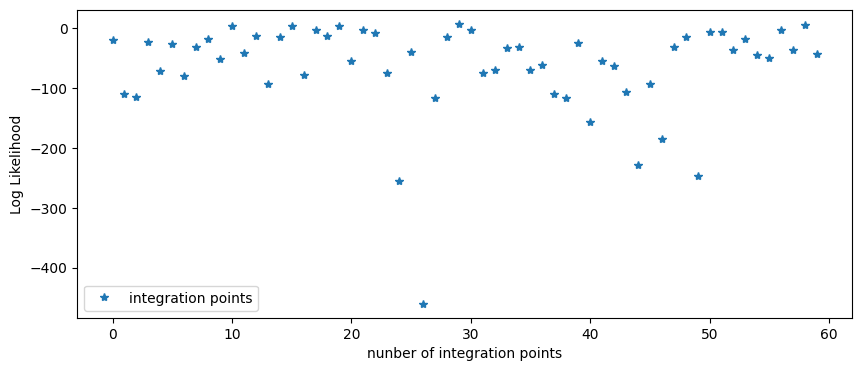

In [26]:
# plot the log likelihood value of the integration of the bayesian neural network
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bnn_model.log_likelihood, '*', label="integration points")
ax.set_xlabel("nunber of integration points")
ax.set_ylabel("Log Likelihood")
plt.legend()
plt.show()



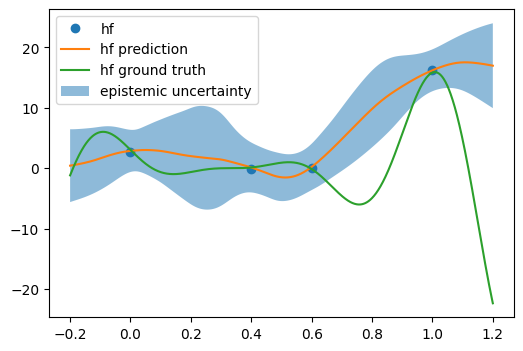

In [27]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    X=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), bnn_y, label="hf prediction")

ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# plot the episitmic uncertainty
ax.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_epistemic).reshape(-1),
    (bnn_y + 2 * bnn_epistemic).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)
# plot aleatoric uncertainty
# ax.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_aleatoric).reshape(-1),
#     (bnn_y + 2 * bnn_aleatoric).reshape(-1),
#     alpha=0.5,
#     label="aleatoric uncertainty",
# )
plt.legend()
plt.show()